## Ch `05`: Concept `03`

## Self-organizing map

Import TensorFlow and NumPy:

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np

Define a class called `SOM`. The constructor builds a grid of nodes, and also defines some helper ops:

In [2]:
class SOM:
    
    def __init__(self, width, height, dim):
        self.num_iters = 100
        self.width = width
        self.height = height
        self.dim = dim
        self.node_locs = self.get_locs()

        # Each node is a vector of dimension `dim`
        # For a 2D grid, there are `width * height` nodes
        nodes = tf.Variable(tf.random_normal([width*height, dim]))
        self.nodes = nodes

        # These two ops are inputs at each iteration
        x = tf.placeholder(tf.float32, [dim])
        iter = tf.placeholder(tf.float32)

        self.x = x
        self.iter = iter

        # Find the node that matches closest to the input
        bmu_loc = self.get_bmu_loc(x)

        self.propagate_nodes = self.get_propagation(bmu_loc, x, iter)
        
    def get_propagation(self, bmu_loc, x, iter):
        '''
        Define the weight propagation function that will update weights of the best matching unit (BMU). 
        The intensity of weight updates decreases over time, as dictated by the `iter` variable.
        '''
        num_nodes = self.width * self.height
        rate = 1.0 - tf.div(iter, self.num_iters)
        alpha = rate * 0.5
        sigma = rate * tf.to_float(tf.maximum(self.width, self.height)) / 2.
        expanded_bmu_loc = tf.expand_dims(tf.to_float(bmu_loc), 0)
        sqr_dists_from_bmu = tf.reduce_sum(tf.square(tf.subtract(expanded_bmu_loc, self.node_locs)), 1)
        neigh_factor = tf.exp(-tf.div(sqr_dists_from_bmu, 2 * tf.square(sigma)))
        rate = tf.multiply(alpha, neigh_factor)
        rate_factor = tf.stack([tf.tile(tf.slice(rate, [i], [1]), [self.dim]) for i in range(num_nodes)])
        nodes_diff = tf.multiply(rate_factor, tf.subtract(tf.stack([x for i in range(num_nodes)]), self.nodes))
        update_nodes = tf.add(self.nodes, nodes_diff)
        return tf.assign(self.nodes, update_nodes)
    
    def get_bmu_loc(self, x):
        '''
        Define a helper function to located the BMU:
        '''
        expanded_x = tf.expand_dims(x, 0)
        sqr_diff = tf.square(tf.subtract(expanded_x, self.nodes))
        dists = tf.reduce_sum(sqr_diff, 1)
        bmu_idx = tf.argmin(dists, 0)
        bmu_loc = tf.stack([tf.mod(bmu_idx, self.width), tf.div(bmu_idx, self.width)])
        return bmu_loc
    
    def get_locs(self):
        '''
        Build a grid of nodes:
        '''
        locs = [[x, y]
            for y in range(self.height)
            for x in range(self.width)]
        return tf.to_float(locs)
    
    def train(self, data):
        '''
        Define a function to training the SOM on a given dataset:
        '''
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.num_iters):
                for data_x in data:
                    sess.run(self.propagate_nodes, feed_dict={self.x: data_x, self.iter: i})
            centroid_grid = [[] for i in range(self.width)]
            self.nodes_val = list(sess.run(self.nodes))
            self.locs_val = list(sess.run(self.node_locs))
            for i, l in enumerate(self.locs_val):
                centroid_grid[int(l[0])].append(self.nodes_val[i])
            self.centroid_grid = centroid_grid

Time to use our newfound powers. Let's test it out on some data:

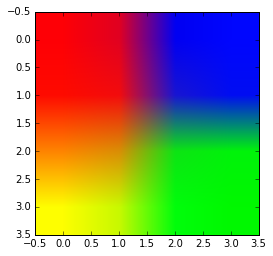

In [3]:
import matplotlib.pyplot as plt

colors = np.array(
     [[0., 0., 1.],
      [0., 0., 0.95],
      [0., 0.05, 1.],
      [0., 1., 0.],
      [0., 0.95, 0.],
      [0., 1, 0.05],
      [1., 0., 0.],
      [1., 0.05, 0.],
      [1., 0., 0.05],
      [1., 1., 0.]])

som = SOM(4, 4, 3)
som.train(colors)

plt.imshow(som.centroid_grid)
plt.show()